<h1 style="text-algin:center; color:blue;"> Image-Based Search and Recommendation System </h1>

### 01. Importing Libraries

In [1]:
import matplotlib.pyplot as plt #for plotting
import numpy as np #for mathematical operations
import pandas as pd #for data manipulation
import joblib #  to dump and load embeddings df
import cv2 # for image manipulation
from sklearn.metrics.pairwise import cosine_similarity #to find similarity between images
from pandas.core.common import flatten  #from pandas to flatten 2-D array

In [2]:
# Importing the below libraries for our model building
import torch
import torch.nn as nn
import torchvision.models as models #cv models
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image
import warnings
warnings.filterwarnings("ignore")

### 02.Load and Preprocess Data

In [11]:
df=pd.read_csv("dataset/styles.csv", on_bad_lines='skip') #df=pd.read_csv("data.csv")
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


<Axes: ylabel='articleType'>

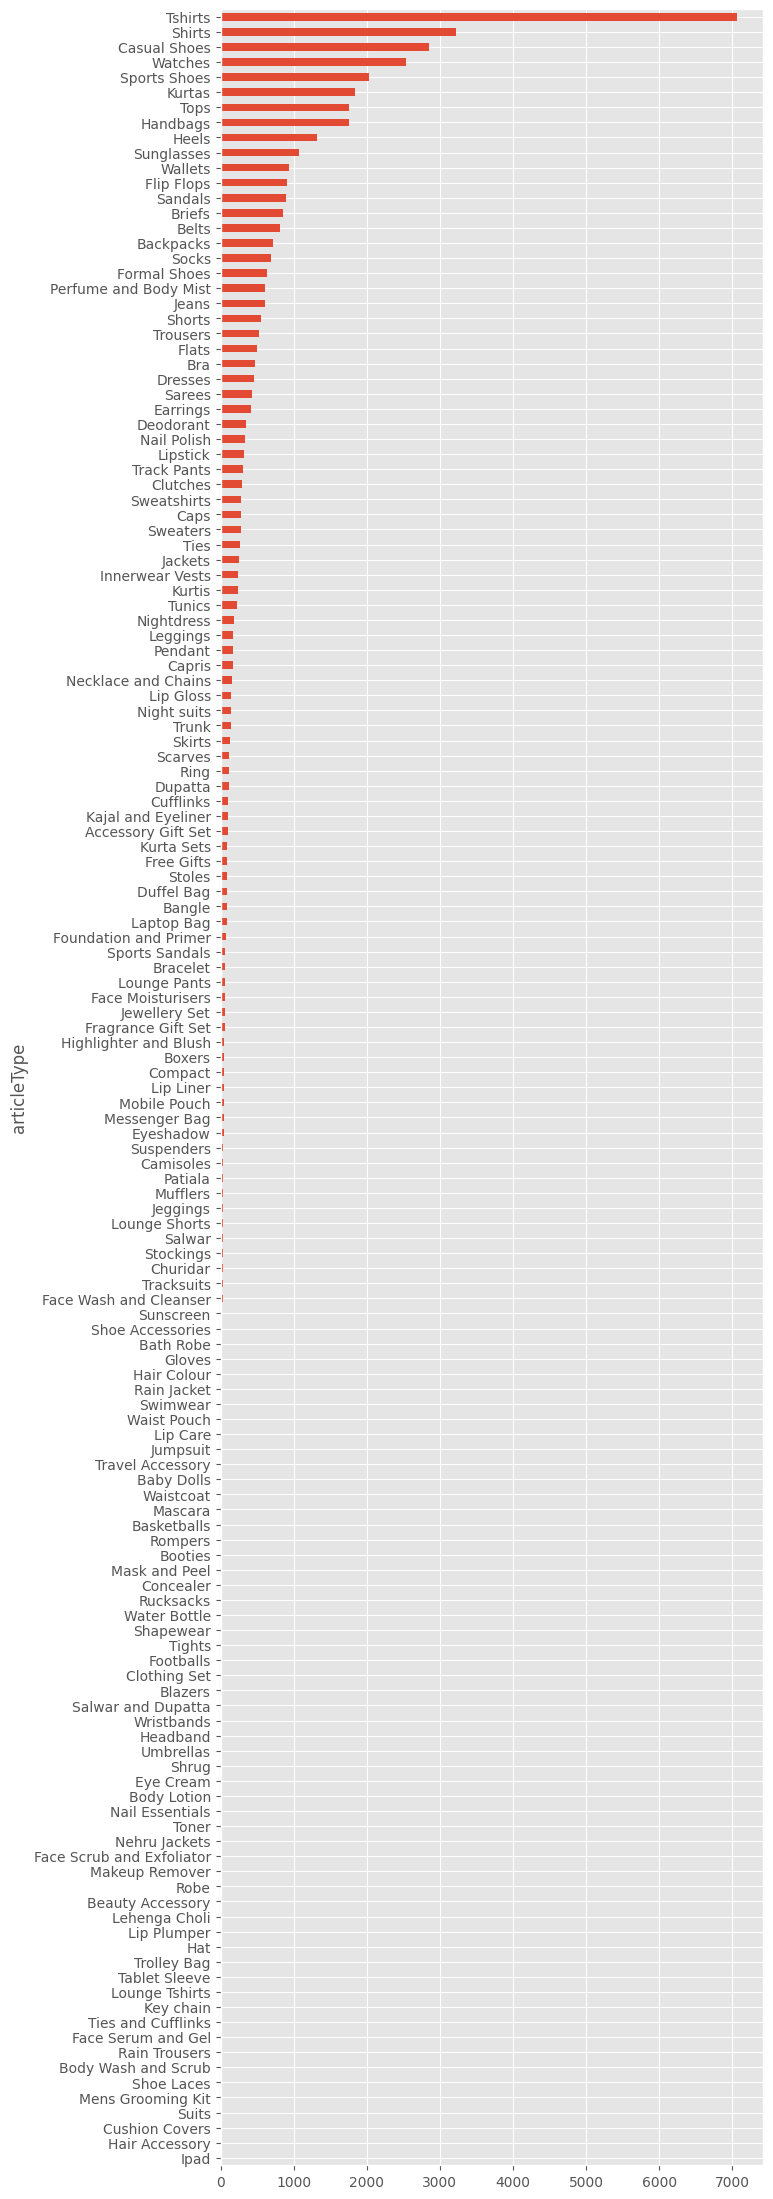

In [14]:
plt.style.use('ggplot') # use ggplot style
plt.figure(figsize=(7,28)) 
df.articleType.value_counts().sort_values().plot(kind='barh')  # Understanding the data, how many different articleType are present and knowing their frequency


<Axes: ylabel='subCategory'>

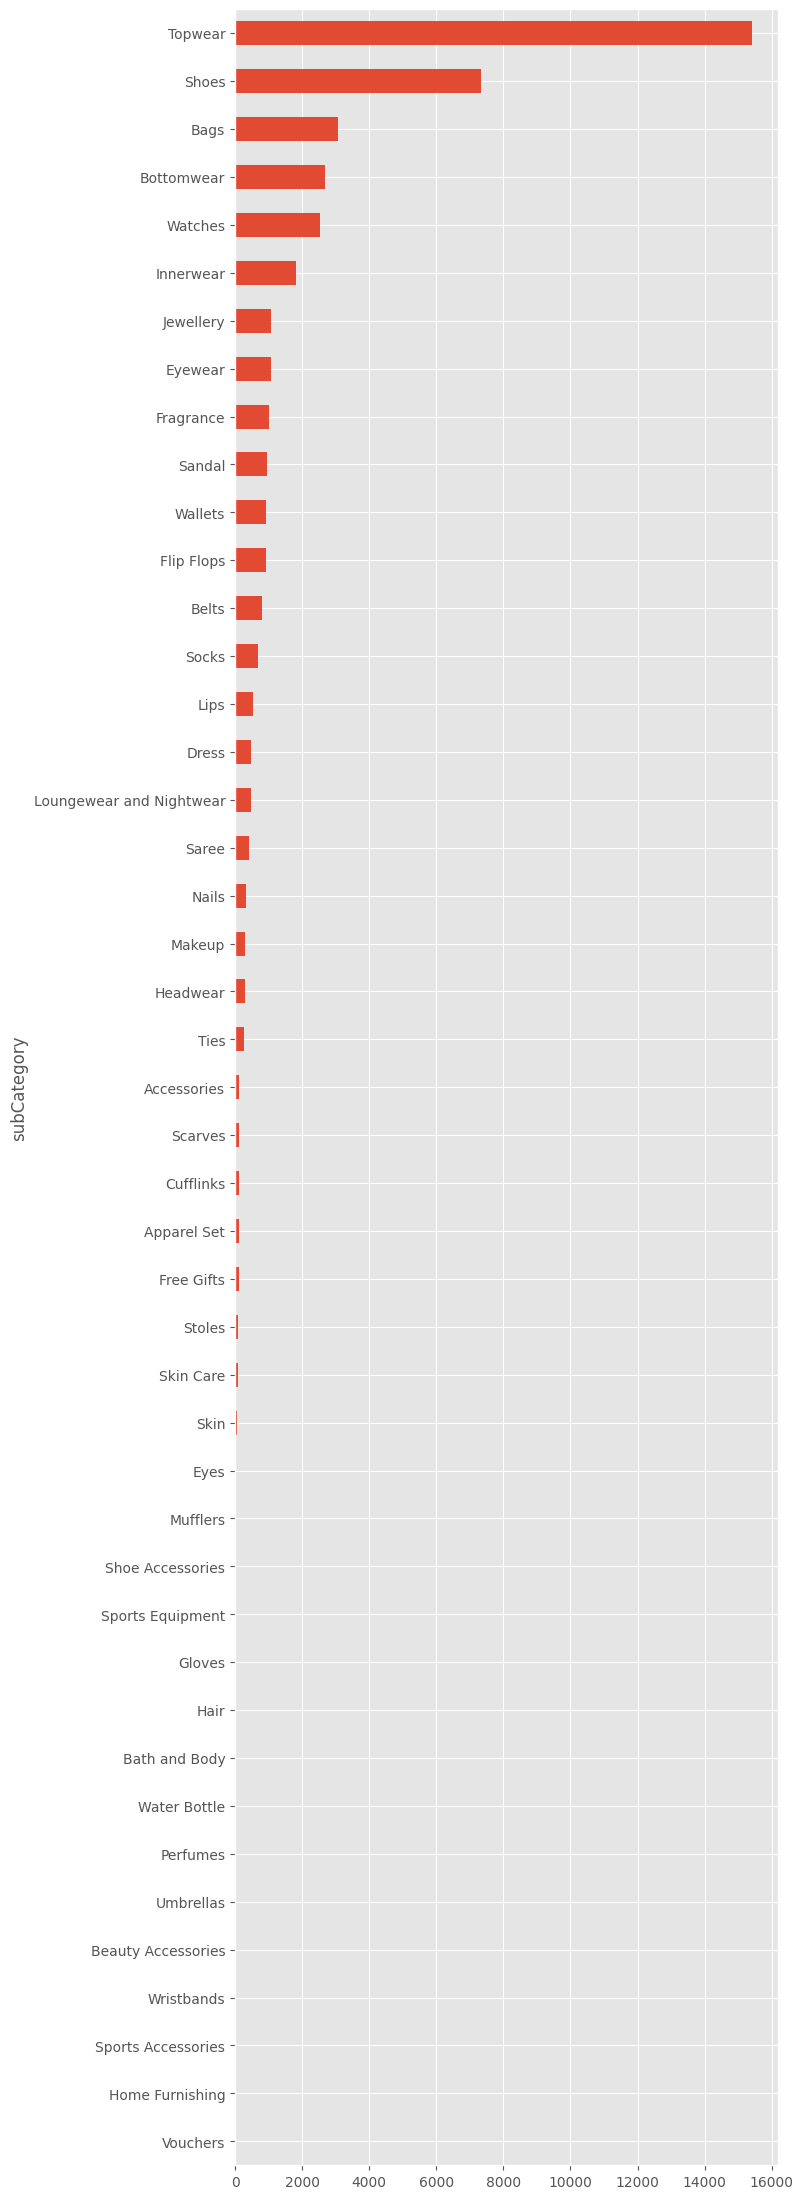

In [15]:
plt.figure(figsize=(7,28))
df.subCategory.value_counts().sort_values().plot(kind='barh')

In [17]:
#creating column to store image location ids
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1 )
 #reseting the index
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [20]:
 #image path
def image_location(img):
    return 'dataset/images/'  + img
 # function to load image
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

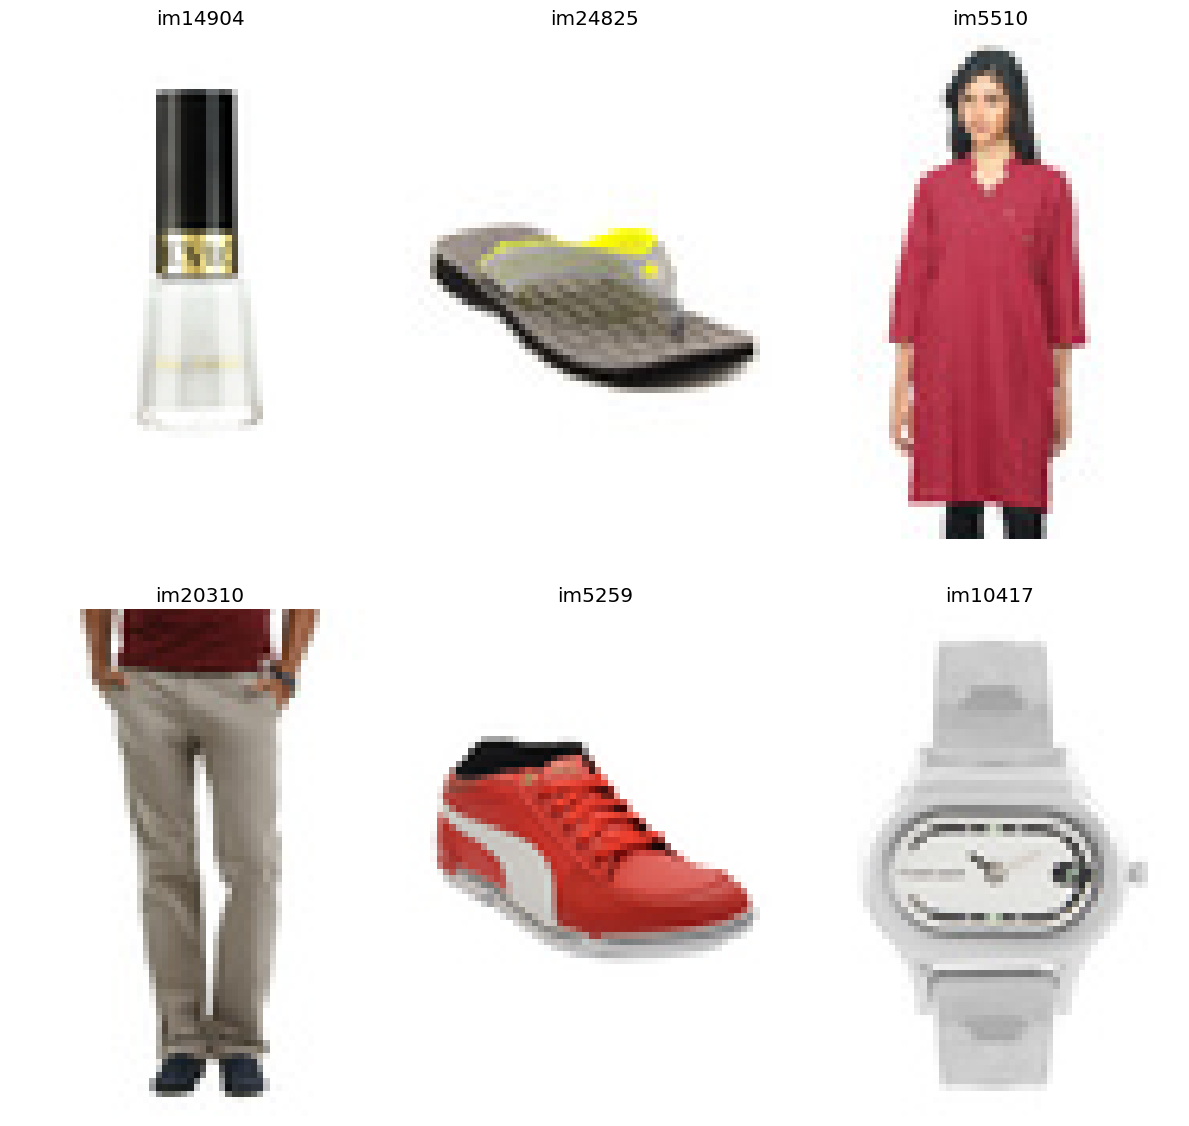

In [27]:
def show_images(images, rows = 1, cols=1,figsize=(12, 12)):
    #define fig
    fig, axes = plt.subplots(ncols=cols,nrows=rows,figsize=figsize)
    #loop for images
    for index,name in enumerate(images):
         axes.ravel()[index].imshow(cv2.cvtColor(images[name],cv2.COLOR_BGR2RGB))
         axes.ravel()[index].set_title(name)
         axes.ravel()[index].set_axis_off()
    #plot
    plt.tight_layout()
# Generation of a dictionary of {index, image}
figures = {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}
 # Plotting the images in a figure, with 2 rows and 3 columns
show_images(figures, 2, 3)

### 03.Features Engineering

In [28]:
# Defining the input shape
width= 224
height= 224
# Loading the pretrained model
resnetmodel = models.resnet18(pretrained=True)
# selecting the layer
layer = resnetmodel._modules.get('avgpool')
#evaluation
resnetmodel.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\SIVA1201/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

(80, 60, 3)
tensor([3.4817e-01, 1.0096e+00, 2.3027e-01, 1.6094e+00, 3.1613e-01, 8.5980e-01,
        4.3306e-01, 1.1168e-01, 1.8218e+00, 1.4897e+00, 1.9399e-01, 8.2331e-01,
        5.5605e-01, 8.9922e-02, 1.8818e-02, 1.3682e-01, 9.4701e-01, 1.0497e-01,
        1.6656e-01, 1.7626e+00, 9.9358e-01, 1.3073e+00, 2.1264e+00, 4.9266e-01,
        1.2562e-01, 2.7388e-01, 6.8457e-01, 3.1402e+00, 6.9369e-02, 4.8551e-01,
        8.1938e-01, 3.3273e-01, 3.4622e-01, 2.4428e+00, 9.3075e-01, 1.1730e+00,
        4.7563e-01, 3.6370e-01, 8.1940e-01, 5.6768e-01, 4.4987e-01, 2.3003e-01,
        1.2730e-01, 1.4716e+00, 2.5265e+00, 2.6489e-01, 1.1693e-01, 3.0466e-01,
        2.3547e+00, 5.5900e-01, 1.4455e+00, 1.1469e+00, 6.1637e-01, 5.6348e-01,
        7.1206e-01, 6.7012e-01, 1.3783e-01, 3.5957e+00, 9.4734e-01, 1.3985e+00,
        2.7163e-01, 5.2888e-01, 5.6491e-01, 5.8260e-01, 1.7505e-01, 4.6431e-02,
        1.2812e+00, 3.6965e-01, 1.1536e+00, 1.3511e+00, 8.4561e-02, 1.8912e+00,
        2.1862e-01, 1.6410e-

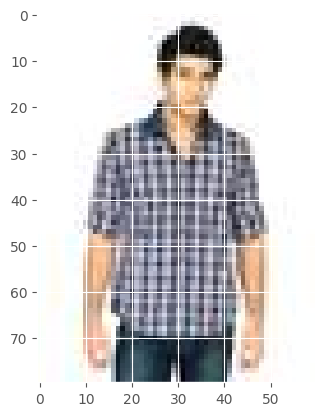

In [33]:
 # scaling the data
s_data = transforms.Resize((224, 224))
 # normalizing
standardize = transforms.Normalize(mean=[0.7, 0.6, 0.3], std=[0.2, 0.3, 0.1]) 
 # converting to tensor
convert_tensor = transforms.ToTensor()
 # creating the missing image object
missing_img = []
 #function to get embeddings
def vector_extraction(resnetmodel, image_id):
    # exception handling to ignore missing images
    try:
        img = Image.open(image_location(image_id)).convert('RGB')
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        embeddings = torch.zeros(512)

        def select_d(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
        hlayer = layer.register_forward_hook(select_d)
        resnetmodel(t_img)
        hlayer.remove()
        emb = embeddings
        return embeddings
    # If file not found
    except FileNotFoundError:
        # Store the index of such entries in missing_img list and drop them later
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)

# Testing if our vector_extraction function works well on sample image
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_0)


(80, 60, 3)
tensor([2.2214e-01, 4.8201e-01, 1.4577e+00, 2.0319e+00, 7.2153e-02, 1.1472e+00,
        3.7525e-01, 1.2374e-01, 1.2103e+00, 1.6589e+00, 4.6383e-01, 1.1207e+00,
        1.8760e-01, 1.6882e-01, 7.9731e-02, 9.6742e-01, 3.4295e-01, 6.1189e-01,
        1.4849e-01, 2.1886e+00, 4.2695e-01, 7.3654e-01, 2.2325e+00, 7.4542e-01,
        3.7189e-01, 2.1022e-01, 2.0852e-01, 3.8510e+00, 0.0000e+00, 7.6034e-01,
        5.2886e-01, 5.1996e-02, 4.3434e-01, 2.9405e+00, 3.0286e+00, 7.1146e-02,
        5.4161e-01, 1.2275e-01, 1.0301e+00, 8.6784e-01, 2.9940e-01, 2.2237e-01,
        2.0470e-01, 5.1393e-01, 8.8564e-01, 1.4416e+00, 4.1729e-01, 1.9291e-01,
        1.4389e+00, 4.5813e-01, 2.1016e+00, 1.2736e+00, 2.7155e-01, 5.5243e-01,
        7.0722e-01, 9.0096e-01, 3.1049e-02, 1.2802e+00, 7.3365e-01, 5.1611e-01,
        2.2345e-01, 1.3885e-01, 1.7405e+00, 1.2096e+00, 5.0332e-01, 7.8591e-01,
        1.8049e+00, 2.8785e-02, 4.2256e-01, 9.1533e-01, 1.3768e+00, 1.5604e+00,
        2.5527e-01, 7.8376e-

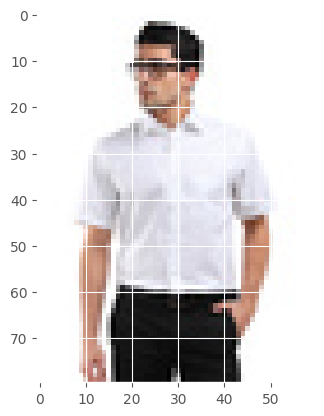

In [37]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_1 = vector_extraction(resnetmodel,df.iloc[1000].image)
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[1000].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_1)

In [41]:
#Finding the similarity between those two images
cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0),sample_embedding_1.unsqueeze(0))
print(f"Cosine similarity: {cos_sim*100}%")

Cosine similarity: [[86.64364]]%


In [45]:
%%time
import swifter
# Applying embeddings on subset of this huge dataset
df_embeddings = df[:5000] #We can apply on entire df, like:df_embeddings = df

#looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))
 #convert to series
df_embs = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply: 100%|██████████| 5000/5000 [02:39<00:00, 31.28it/s]


(5000, 512)
CPU times: total: 11min 24s
Wall time: 2min 59s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.348166,1.009573,0.230270,1.609439,0.316126,0.859798,0.433056,0.111684,1.821786,1.489676,...,0.605075,0.910010,2.286938,0.562117,0.002573,0.157162,1.885741,1.420860,0.000000,0.504326
1,0.754325,0.232688,0.522141,2.608785,0.838683,0.135893,0.427806,0.854114,0.601941,2.225886,...,0.222548,0.424173,0.006582,0.189141,0.000000,0.156890,1.189896,0.405764,0.087879,0.134553
2,0.331701,0.240245,3.068740,2.655945,0.009184,0.013016,3.198415,0.591138,3.220151,4.040012,...,0.303095,3.104078,1.619335,0.973719,0.458846,0.000000,1.401981,0.908382,0.000000,0.000000
3,0.624760,0.258359,0.544933,2.922386,0.353659,0.141807,0.799509,0.617608,0.298829,0.843660,...,0.320797,0.392779,0.261849,0.159667,0.000000,0.005314,0.677280,0.223055,0.063506,0.190920
4,0.452777,0.649997,0.348728,1.654589,0.135157,1.385381,0.481831,0.515382,2.859255,1.028548,...,0.432273,0.875068,1.472378,0.889062,0.074484,0.321774,1.748126,0.052523,0.000000,0.241553


In [47]:
#export the embeddings
df_embs.to_csv('df_embs.csv')
# importing the embeddings
df_embs = pd.read_csv('df_embs.csv')
df_embs.drop(['Unnamed: 0'],axis=1,inplace=True)
df_embs.dropna(inplace=True)
#exporting as pkl
joblib.dump(df_embs, 'df_embs.pkl', 9)
#importing the pkl
df_embs = joblib.load('df_embs.pkl')

In [50]:
# Calculating similarity between images ( using embedding values )
cosine_sim = cosine_similarity(df_embs)
 # Previewing first 4 rows and 4 columns similarity just to check the structure of cosine_sim
cosine_sim[:4, :4]

array([[1.        , 0.74227736, 0.61631324, 0.76462854],
       [0.74227736, 1.        , 0.64025624, 0.87229402],
       [0.61631324, 0.64025624, 1.        , 0.60693881],
       [0.76462854, 0.87229402, 0.60693881, 1.        ]])

In [67]:
# Storing the index values in a series index_vales for recommending
index_vales = pd.Series(range(len(df)), index=df.index)
index_vales
# Defining a function that gives recommendations based on the cosine similarity score
def recommend_images(ImId, df, top_n = 6):
    # Assigning index of reference into sim_ImId
    sim_ImId = index_vales[ImId]
    # Storing cosine similarity of all other items with item requested by user in sml_scr as a list
    sml_scr = list(enumerate(cosine_sim[sim_ImId]))
    # Sorting the list of sml_scr
    sml_scr = sorted(sml_scr, key=lambda x: x[1], reverse=True)
    # Extracting the top n values from sml_scr
    sml_scr = sml_scr[1:top_n+1]
    # ImId_rec will return the index of similar items
    ImId_rec= [i[0] for i in sml_scr]
    # ImId_sim will return the value of similarity score
    ImId_sim= [i[1] for i in sml_scr]
    return index_vales.iloc[ImId_rec].index, ImId_sim
# Sample given below
recommend_images(3810, df, top_n = 5)

(Index([3899, 3678, 3967, 4746, 4384], dtype='int64'),
 [0.9999982645876687,
  0.9999979826604338,
  0.999997764546413,
  0.9999976463282039,
  0.9999975143713483])

In [99]:
def Rec_viz_image(input_imageid):
   # Getting recommendations
   idx_rec, idx_sim = recommend_images(input_imageid, df,top_n = 6)
   # Printing the similarity score
   print (idx_sim)
   # Plotting the image of item requested by user
   plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))
   # Generating a dictionary of { index, image }
   figures = {'im'+str(i): import_img(row.image) for i, row in 
   df.loc[idx_rec].iterrows()}
   # Plotting the similar images in a figure, with 2 rows and 3 columns
   show_images(figures, 2, 3)
Rec_viz_image(3810)

[0.9999982645876687, 0.9999979826604338, 0.999997764546413, 0.9999976463282039, 0.9999975143713483, 0.9999969381752081]


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [100]:
Rec_viz_image(2617)

[0.9999928011327168, 0.9999920331837828, 0.999990669898424, 0.9999906459280828, 0.9999900454044433, 0.9999898151389404]


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [86]:
def recm_user_input(image_id):
    # Loading image and reshaping it
    img = Image.open('dataset/images/' + image_id).convert('RGB')
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
    embeddings = torch.zeros(512)
    def select_d(m, i, o):
      embeddings.copy_(o.data.reshape(o.data.size(1)))
    hlayer = layer.register_forward_hook(select_d)
    resnetmodel(t_img)
    hlayer.remove()
    emb = embeddings
    # Calculating Cosine Similarity
    cs = cosine_similarity(emb.unsqueeze(0),df_embs.iloc[:, :512])
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list,columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'],ascending=False)
    # Printing Cosine Similarity
    print(cs_df['Score'][:10])
    # Extracting the index of top 10 similar items/images
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []
    for i in top10:
       image_id = df[df.index==i]['image']
       images_list.append(image_id)
    images_list = list(flatten(images_list))
    # Plotting the image of item requested by user
    img_print = Image.open('dataset/images/' + image_id)
    plt.imshow(img_print)
    # Generating a dictionary { index, image }
    figures = {'im'+str(i): Image.open('dataset/newLmg/' + i) for i in images_list}
    #  Plotting the similar images in a figure, with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 5, figsize = (8,8) )
    for index,name in enumerate(figures):
      axes.ravel()[index].imshow(figures[name])
      axes.ravel()[index].set_title(name)
      axes.ravel()[index].set_axis_off()
    plt.tight_layout()

In [92]:
recm_user_input('1530.jpg')

1     0.448604
2     0.445806
7     0.438844
3     0.433040
9     0.417354
12    0.416643
10    0.413542
4     0.410635
6     0.405387
0     0.405275
Name: Score, dtype: float64


AttributeError: 'Series' object has no attribute 'read'